In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from math import pi

import colorsys
def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

def item_name_format(item_name):
    return(item_name.replace(" / ","-").replace(" ", "_").replace("%",""))

In [2]:
###----- Output directory
out_dir = "Salad_planner_database_plots"

In [3]:
###----- Set up daily caloric requirement
tot_cal = 1800
tot_cal_pctg = {"Carb": 0.3, "Protein": 0.4, "Fat": 0.3, "SatFat": 0.1, "Sugar": 0.05}
tot_cal_dict = {x:tot_cal*tot_cal_pctg[x] for x in tot_cal_pctg.keys()}
# Calculate weight for each category
cal_density_dict = {"Carb": 4, "Protein": 4, "Fat": 9, "SatFat": 9, "Sugar": 4}
tot_weight_dict = {x:tot_cal_dict[x]/cal_density_dict[x] for x in cal_density_dict.keys()}
tot_weight_dict['Fiber'] = 30

In [4]:
###----- Input database process
db_file = "Salad_planner_database.xlsx"
db_df = pd.read_excel(db_file)

# Calculate percentage of daily requirement
db_df['Cal. %'] = db_df['Calories per cup (240ml)'] / tot_cal * 100 # Based on cal
db_df['Fat %'] = db_df['Fat (g)'] / tot_weight_dict['Fat'] * 100 # Based on g
db_df['Sat. fat %'] = db_df['Saturated fat (g)'] / tot_weight_dict['SatFat'] * 100 # Based on g
db_df['Carb %'] = db_df['Total Carb (g)'] / tot_weight_dict['Carb'] * 100 # Based on g
db_df['Sugar %'] = db_df['Sugar (g)'] / tot_weight_dict['Sugar'] * 100 # Based on g
db_df['Prot. %'] = db_df['Protein (g)'] / tot_weight_dict['Protein'] * 100 # Based on g
db_df['Fiber %'] = db_df['Dietary fiber (g)'] / tot_weight_dict['Fiber'] *100 # Based on g

# Parameters to use in plotting
pctg_key_list = ['Cal. %', 'Prot. %', 'Fat %', 'Sat. fat %', 'Carb %', 'Fiber %', 'Sugar %']
pctg_key_col_dict = {'Cal.': 'gray', 
                     'Fat': "darkorange", 
                     'Sat. fat': "orangered", 
                     'Carb': "firebrick", 
                     'Sugar': "maroon", 
                     'Prot.': "royalblue", 
                     'Fiber': "forestgreen"}
cat_col_dict = {"Green": "forestgreen", "Yellow": "gold", "Orange": "darkorange", "nan":"white"}
cat_col_adj_dict = {"forestgreen":2.5, "gold":1.5, "darkorange":1.5, "white":1}

/var/folders/yj/68pdbk192njf76jxx4ml0z4w0000gn/T/ipykernel_39302/1487934710.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(2, 3), dpi=150)


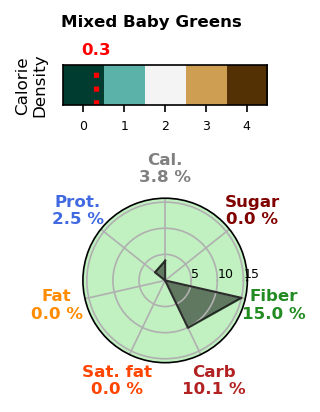

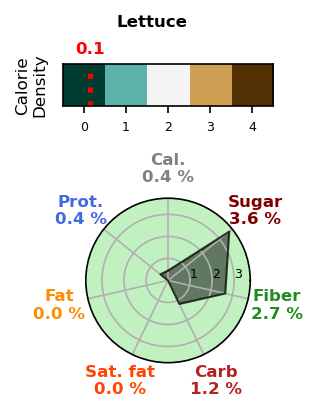

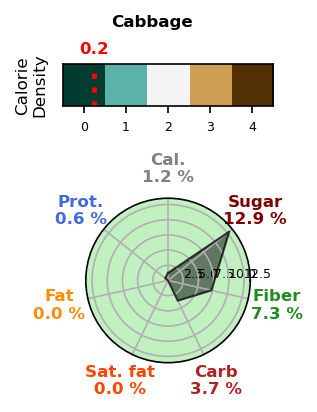

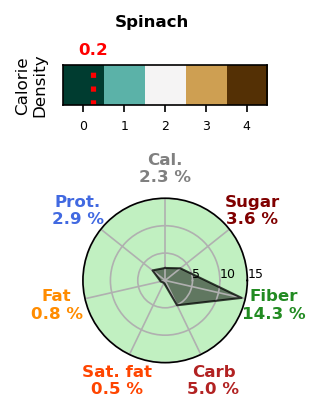

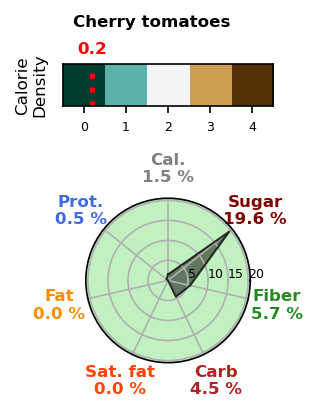

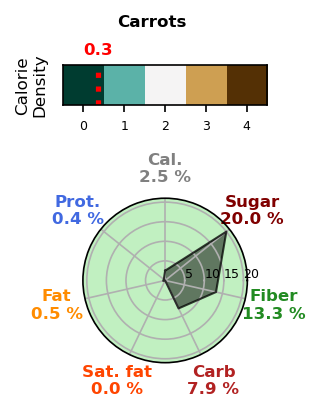

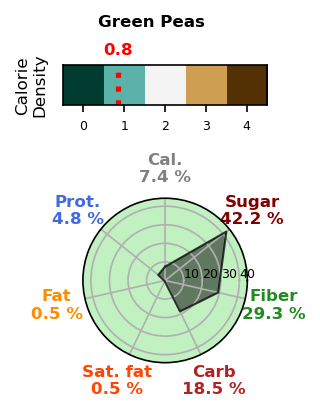

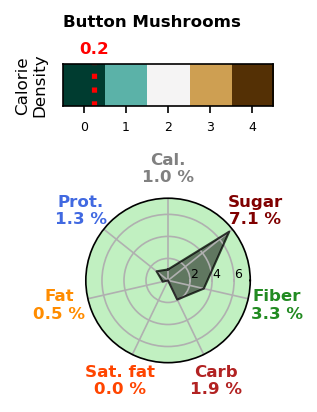

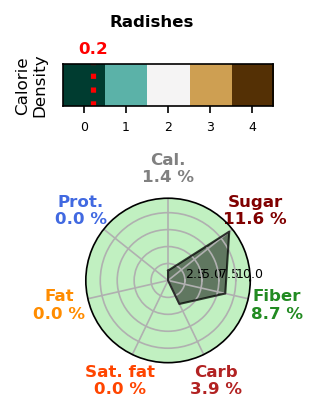

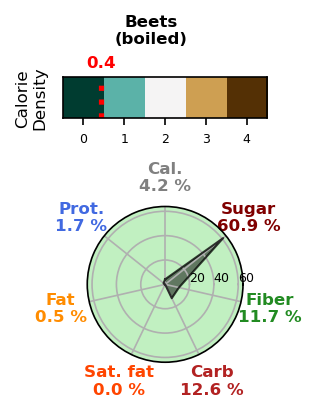

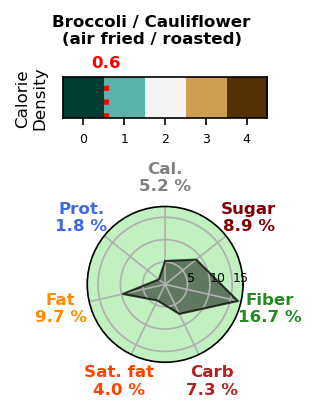

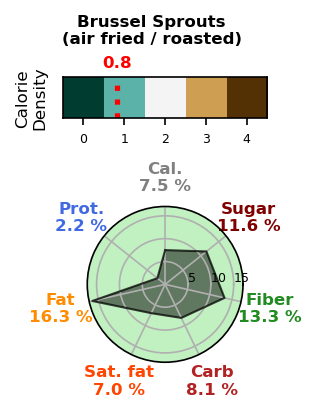

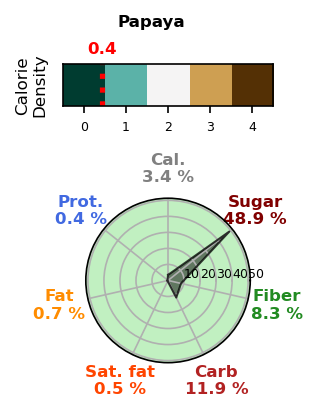

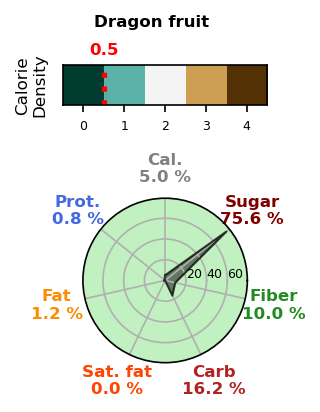

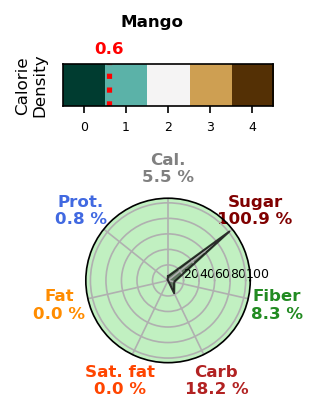

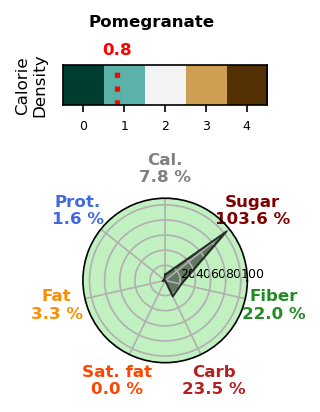

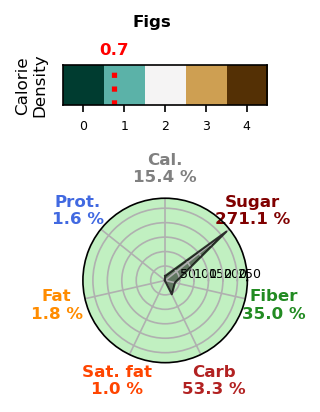

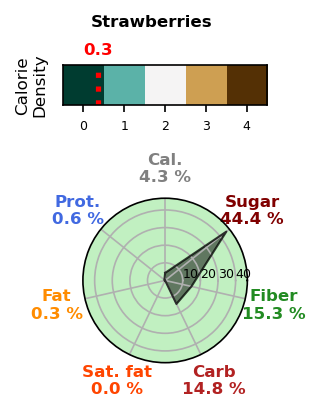

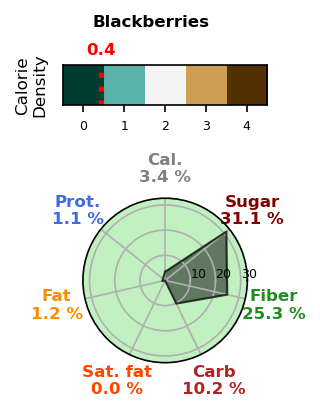

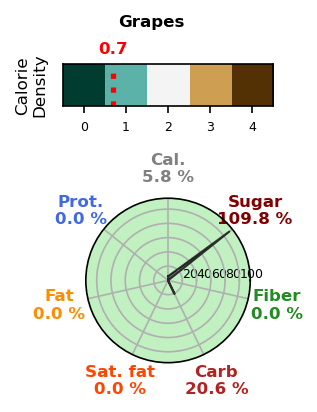

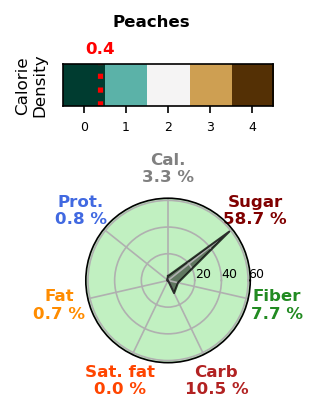

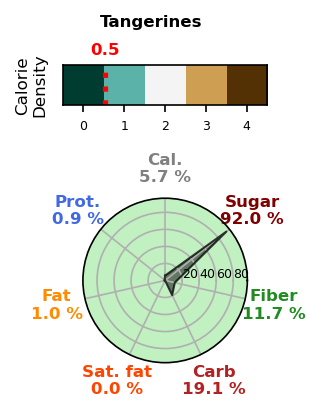

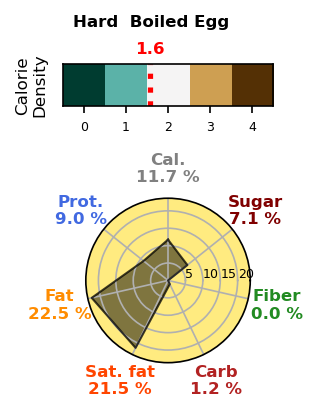

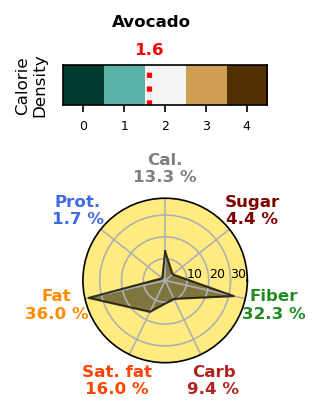

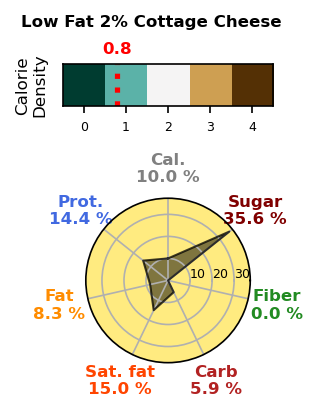

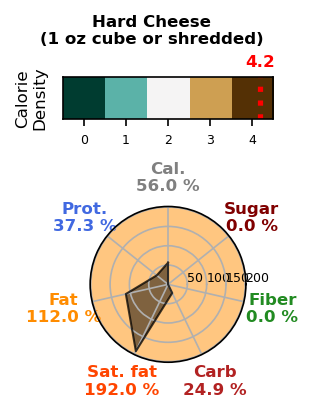

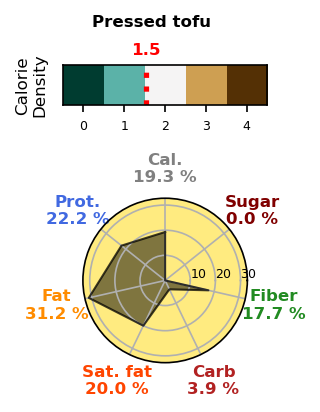

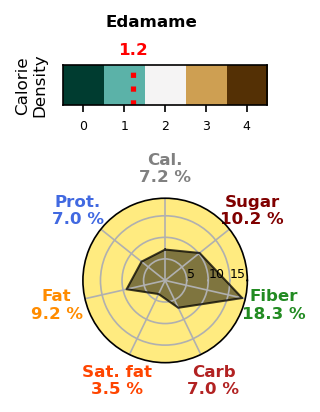

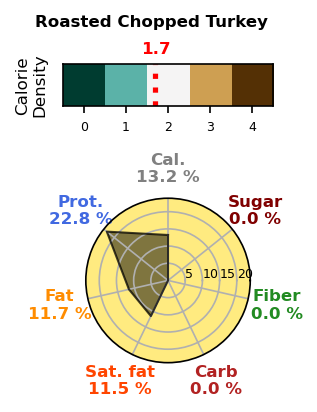

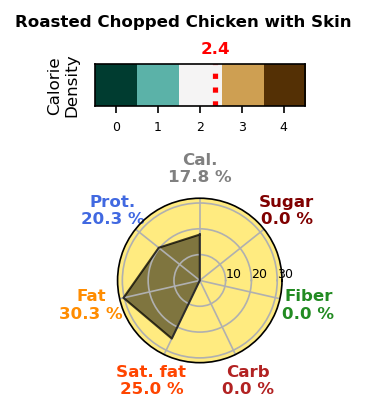

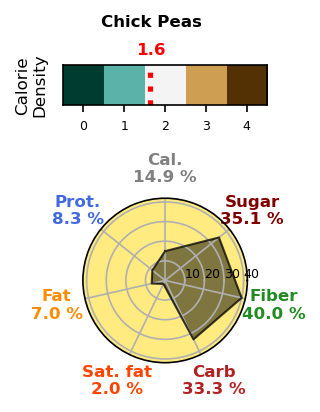

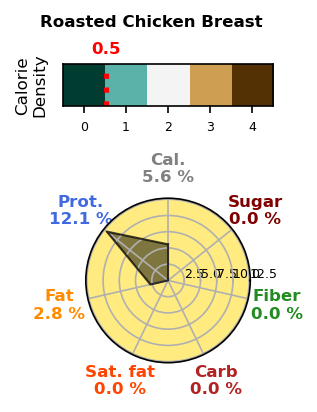

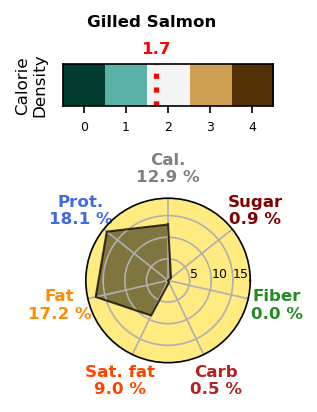

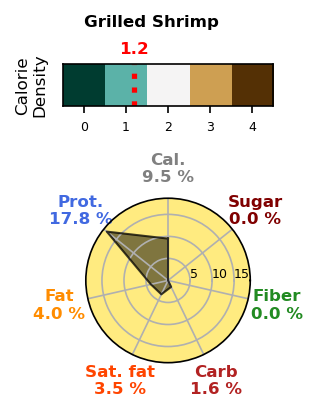

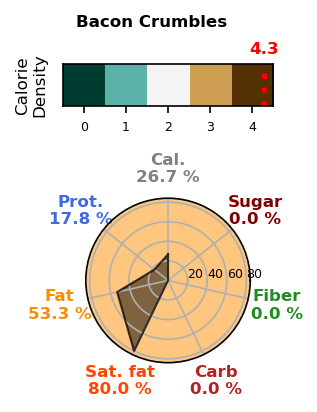

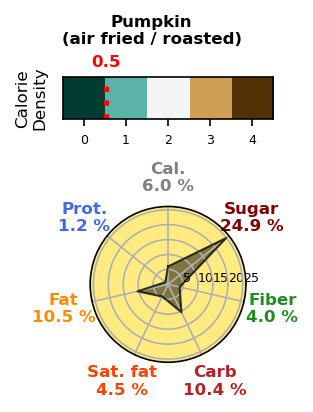

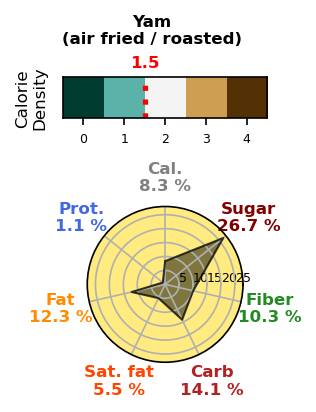

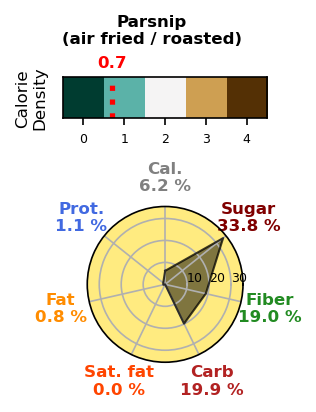

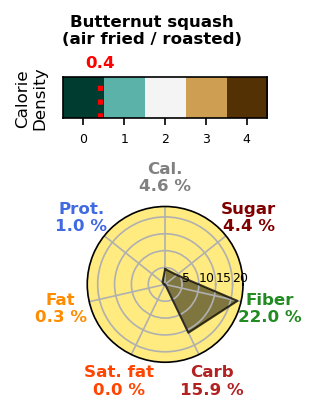

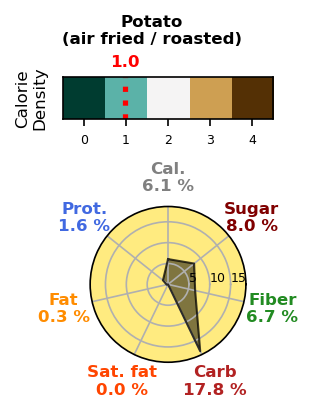

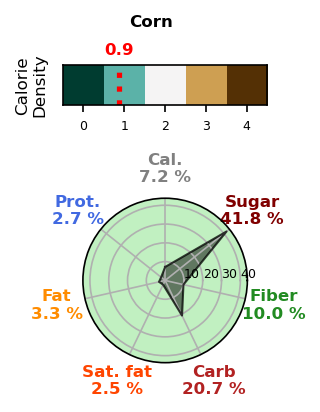

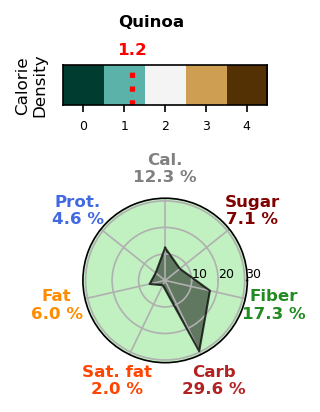

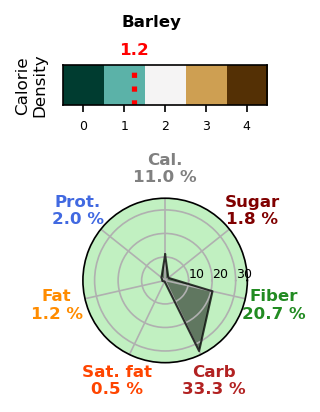

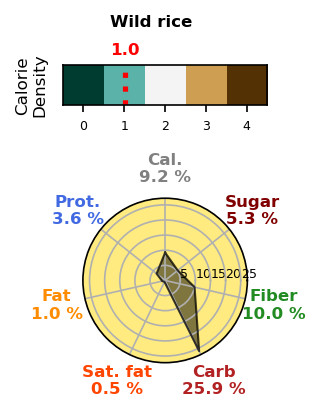

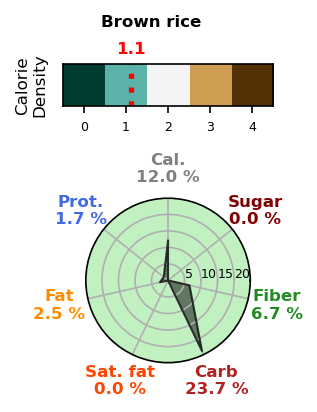

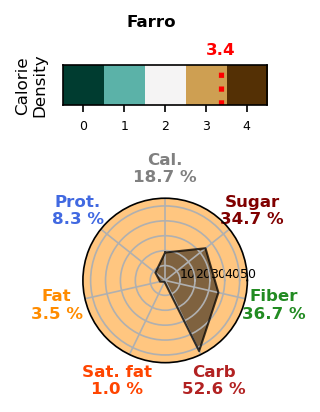

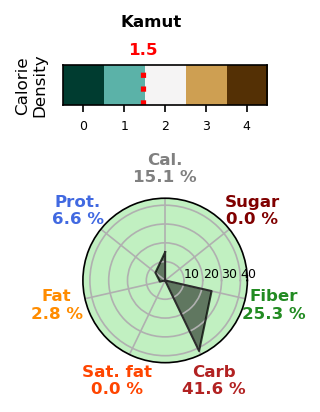

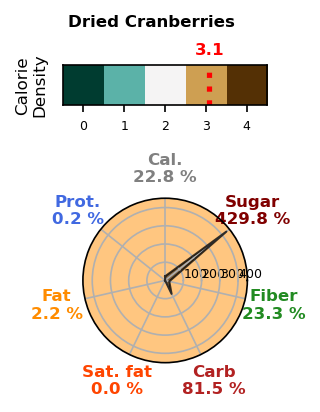

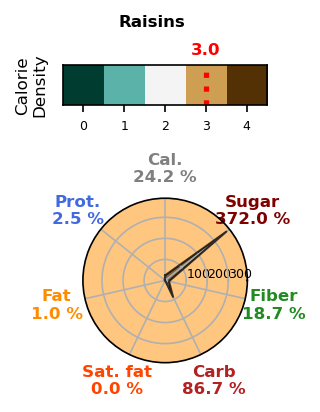

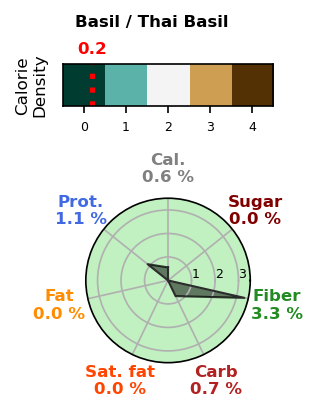

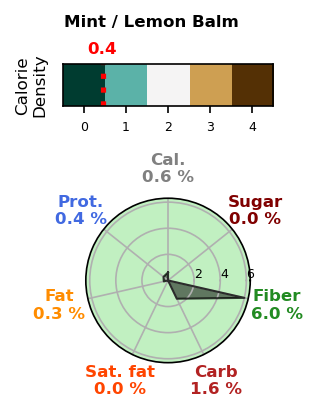

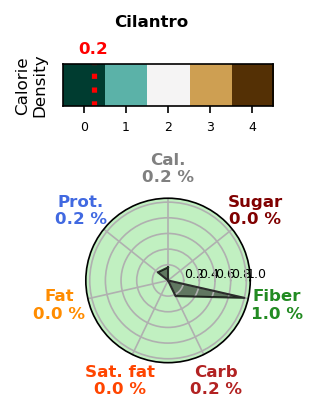

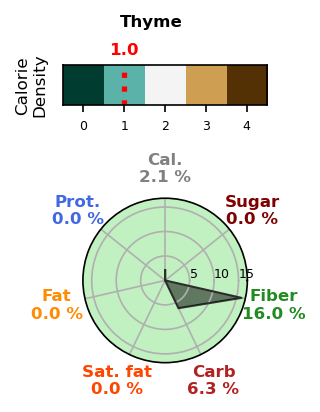

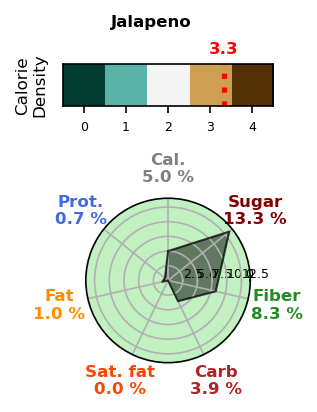

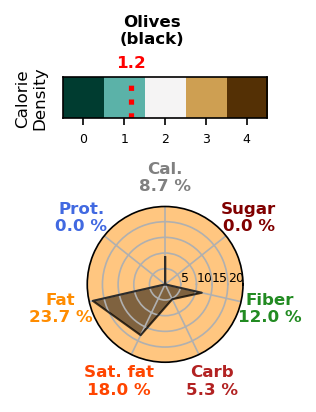

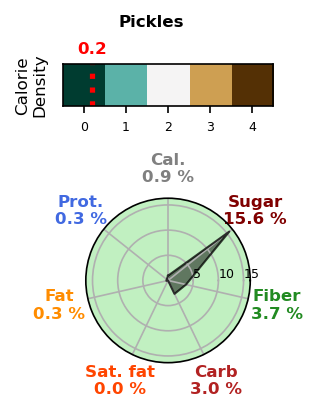

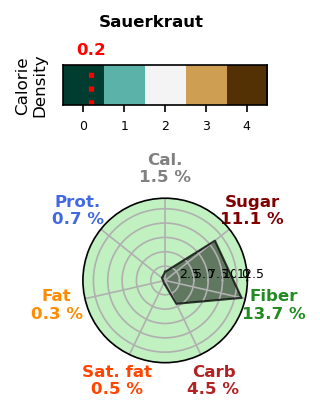

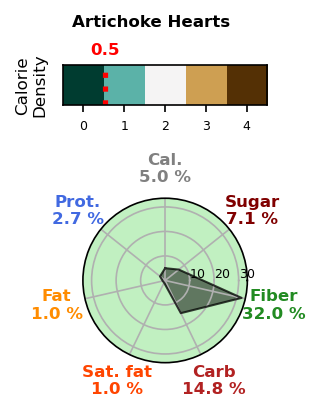

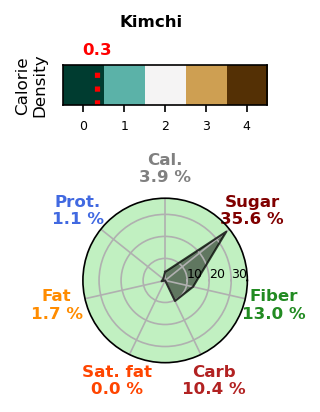

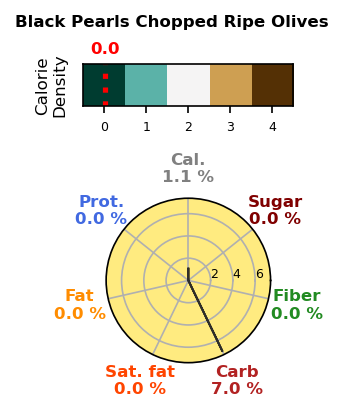

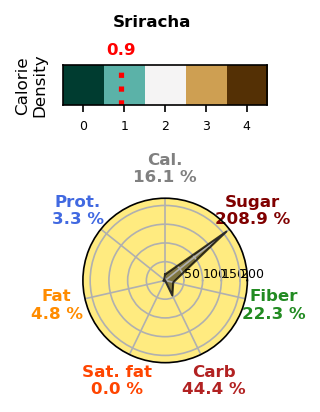

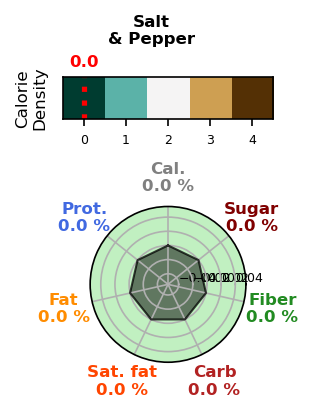

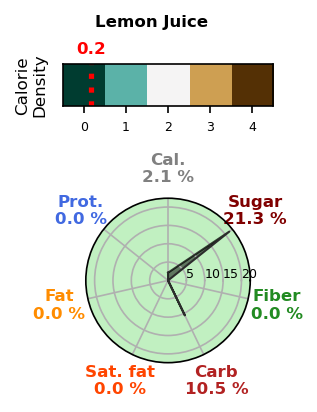

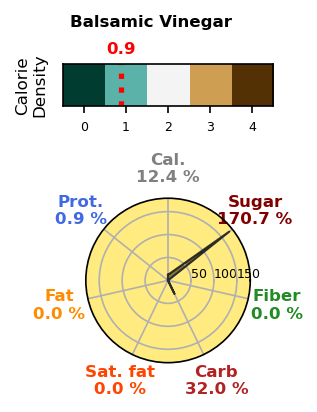

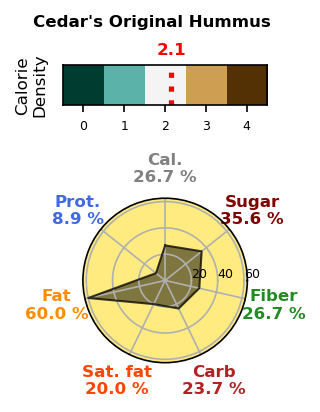

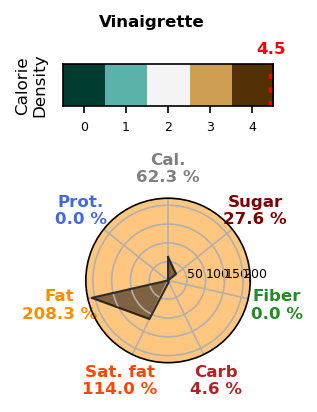

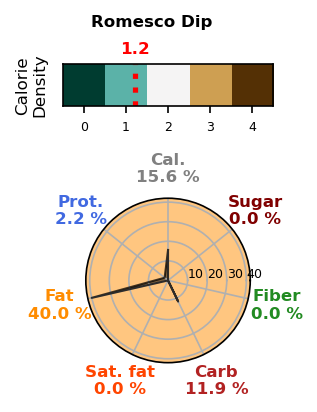

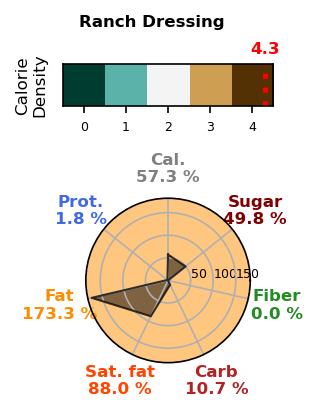

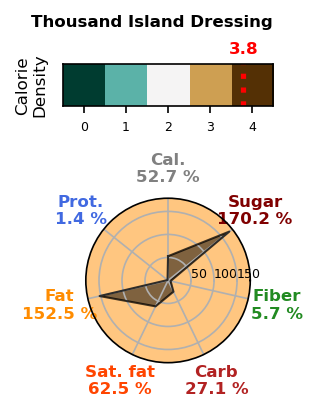

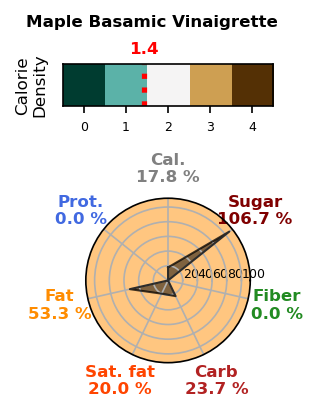

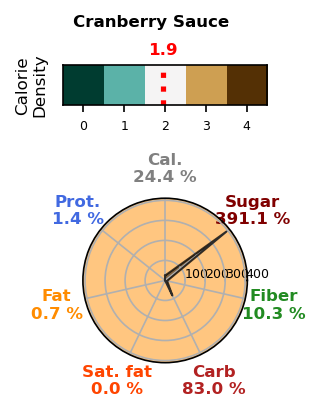

In [5]:
for row_i in db_df.index:
    # Get information of item
    id_i = str(db_df.loc[row_i]['ID'])
    name_i = str(db_df.loc[row_i]['Name'])
    cat_i = str(db_df.loc[row_i]['Category'])
    pctg_list_i = [db_df.loc[row_i][x] for x in pctg_key_list]
    cd_i = db_df.loc[row_i]['Calories per gram']

    # Setup background color based on category of food
    cat_i_col = cat_col_dict[cat_i]
    cat_i_col = matplotlib.colors.ColorConverter.to_rgb(cat_col_dict[cat_i])
    cat_i_col = scale_lightness(cat_i_col, cat_col_adj_dict[cat_col_dict[cat_i]])


    ##########-------------------- Plotting
    figure(figsize=(2, 3), dpi=150)
    matplotlib.rcParams.update({'font.size': 6})

    ###----- Heatmap
    ax0 = plt.subplot(211)
    ax0.set_aspect(0.25)

    gradient = np.linspace(0,1,5)
    gradient = np.vstack((gradient, gradient))
    cmap_name="BrBG_r"

    ax0.imshow(gradient, cmap=cmap_name)
    cd_i_loc = min(cd_i, 4.45)
    if str(pctg_list_i[0]) != "nan":
        ax0.axvline(x=cd_i_loc, color='red', linewidth=2.5, linestyle=':')
    ax0.set_ylim(0,1)
    ax0.set_yticks([])
    ax0.set_ylabel("Calorie\nDensity", size=8)
    ax0.text(cd_i_loc, 1.25, "{:.1f}".format(cd_i), horizontalalignment='center', color='red', size=8, fontweight='bold')
    

    ###----- Radar plot
    categories = pctg_key_list
    ax1 = plt.subplot(212, polar=True)
    ax1.set_rlabel_position(0)
    pctg_list_i += pctg_list_i[:1]
    N = len(categories)

    angles = [(n / float(N) * 2 * pi + 2*pi*1/4) for n in range(N)]
    angles += angles[:1]
    angles = [x - 2*pi if x > 2*pi else x for x in angles]

    # Draw one axe per variable + add labels
    x_labels = ["{}\n{:.1f} %".format(cat.replace(" %",""), pctg) for 
                index,(cat, pctg) in enumerate(zip(categories, pctg_list_i))]
    ax1.set_xticks(angles[:-1], x_labels, size=8, fontweight='bold')
    ax1_xticklabels = ax1.get_xticklabels()
    ax1_xtibklabel_texts = [x.get_text() for x in ax1_xticklabels]
    for xtick, color in zip(ax1_xticklabels, [pctg_key_col_dict[x.split("\n")[0]] for x in ax1_xtibklabel_texts]):
        xtick.set_color(color)
    
    if str(pctg_list_i[0]) != "nan":
        # Plot data
        ax1.plot(angles, pctg_list_i, linewidth=1, linestyle='solid', color='black', alpha=0.75)

        # Fill area
        ax1.fill(angles, pctg_list_i, 'black', alpha=0.5)
        ax1.set_facecolor(cat_i_col)

    ###----- Save
    name_i_use = name_i.replace(" &","\n&").replace(" (","\n(") # Prevent text from being too long
    plt.suptitle(name_i_use,y=0.88, fontsize=8, fontweight='bold')
    plt.tight_layout()

    # Show the graph
    name_i_save = item_name_format(name_i)
    out_name = '%s/%s___%s.png'%(out_dir, id_i, name_i_save.replace(" ", "_"))
    plt.savefig(out_name)

In [6]:
# Generate placeholder
figure(figsize=(2, 3), dpi=150)
out_name = '%s/0_empty.png'%(out_dir)
plt.savefig(out_name)

<Figure size 300x450 with 0 Axes>